## Check Device

In [6]:
import torch

device = (
    "cuda" if torch.cuda.is_available()
    # else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} as backend.")
if device == "cuda":
  !nvidia-smi

Using cpu as backend.


## Define Diode Pair Dataloader Function

In [7]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.special import wrightomega
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

def diode_pair_lambert(a, R, num_up, num_down, model=None):
    Is = 50e-9
    eta = 1.0
    Vt = 25.8563e-3 * eta

    if model == "1N4148":
        Is = 2.52e-9
        eta = 1.752
        Vt = 25.8563e-3 * eta

    lambda_ = np.sign(a)
    mu_0 = np.where(a >= 0, num_down, num_up)
    mu_1 = np.where(a >= 0, num_up,   num_down)

    arg_f = np.log((Is * R) / (mu_0 * Vt)) + (lambda_ * a) / (mu_0 * Vt)
    arg_r = np.log((Is * R) / (mu_1 * Vt)) - (lambda_ * a) / (mu_1 * Vt)
    b = a - 2 * Vt * lambda_ * (mu_0 * wrightomega(arg_f) - mu_1 * wrightomega(arg_r))
    return b


def diodePair_dataset_generate(N: int, num_up=1, num_down=1, model=None, r_begin=300, r_end=3e3):
    a_MIN = -1
    a_MAX = -a_MIN

    a_dp = np.random.uniform(low=a_MIN, high=a_MAX, size=(N, ))
    R_log_dp = np.random.uniform(low=np.log10(r_begin), high=np.log10(r_end), size=(N, ))
    b_dp = diode_pair_lambert(a=a_dp, R=np.power(10, R_log_dp), num_up=num_up, num_down=num_down, model=model)

    aR_dp = np.stack((a_dp, R_log_dp), axis=1)
    return aR_dp, b_dp


def diodePair_dataset_load(N, num_up=1, num_down=1, r_begin=None, r_end=None):
    r_begin_str = f"{r_begin / 1000:.2f}k"
    r_end_str   = f"{r_end   / 1000:.2f}k"
    data_path = ( "./LTspice_data" +
                  f"/{num_up}u{num_down}d" + "/diode_pair" + f"_{num_up}u{num_down}d" +
                  f"_{r_begin_str}" + f"_{r_end_str}"
    )

    v_i_path = data_path + "_i.wav"
    v_o_path = data_path + "_o.wav"
    r_path   = data_path + "_r.wav"

    v_i, fs = librosa.load(path=v_i_path, sr=None, mono=True)
    v_o, _  = librosa.load(path=v_o_path, sr=None, mono=True)
    r,   _  = librosa.load(path=r_path,   sr=None, mono=True)

    if len(v_i) != len(v_o):
        raise ValueError("The length of v_in and v_out are not same!")
    if len(v_i) != len(r):
        raise ValueError("The length of v_in and r are not same!")

    if N <= len(v_i):
        v_i = v_i[:N]
        v_o = v_o[:N]
        r   = r  [:N]
    else:
        raise ValueError("The N must be less or equal than the length of audio files.")

    a_dp = v_i
    b_dp = 2 * v_o - v_i

    r_dp = r_begin + (r_end - r_begin) * r
    r_dp_normalized = r_dp / 3e3

    aR_dp = np.stack((a_dp, r_dp_normalized), axis=1)
    return aR_dp, b_dp, fs


def get_diodePair_dataloader(N, num_up=1, num_down=1, mode="w", model="1N4148", r_begin=10e3, r_end=100e3, batch_size=16, split_ratio=0.8, shuffle=True, random_state=42, plot=False):
    aR_dp = np.zeros((N, 2), dtype=np.float64)
    b_dp  = np.zeros((N,  ), dtype=np.float64)
    Fs = None

    if mode == "w":
        aR_dp, b_dp = diodePair_dataset_generate(N, num_up=num_up, num_down=num_down, r_begin=r_begin, r_end=r_end, model=model)
    elif mode == "LTspice":
        aR_dp, b_dp, Fs = diodePair_dataset_load(N, num_up=num_up, num_down=num_down, r_begin=r_begin, r_end=r_end)

    if plot:
        fig_size = (11, 5)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)

        ax1.scatter(aR_dp[:, 0], b_dp, s=1)
        ax1.set_xlabel('Incident Wave [V]')
        ax1.set_ylabel('Reflected Wave [V]')
        ax1.set_xlim([-1, 1])
        ax1.set_ylim([-1, 1])

        ax2.hist(aR_dp[:, 1], bins=100, density=True)
        ax2.set_xlabel('Free Parameter Normalized R')
        ax2.set_ylabel('Density')

        plt.show()

    aR_dp_train, aR_dp_valid, b_dp_train, b_dp_valid = train_test_split(
        aR_dp, b_dp,
        train_size=split_ratio,
        shuffle=shuffle,
        random_state=random_state
    )

    train_ds = TensorDataset(
        torch.tensor(aR_dp_train, dtype=torch.float32).to(device),
        torch.tensor(b_dp_train,   dtype=torch.float32).to(device),
    )
    valid_ds = TensorDataset(
        torch.tensor(aR_dp_valid, dtype=torch.float32).to(device),
        torch.tensor(b_dp_valid,   dtype=torch.float32).to(device)
    )

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

    return train_dl, valid_dl, Fs

## Define Neural Diode Pair Model

In [8]:
from torch import nn
from typing import Callable

class DiodePair(nn.Module):
    def __init__(self, num_layers: int, layer_size: int, input_size: int = 2, output_size: int = 1, activation_fn: Callable = torch.relu):
        """
        A fully connected neural network module of WDF diode pair .

        Args:
            num_layers: The number of layers in the network.
            layer_size: The size of each layer.
            input_size: The size of the input layer. Defaults to 2.
            output_size: The size of the output layer. Defaults to 1.
            activation_fn: The activation function to use. Defaults to ReLU.
        """
        super().__init__()
        self.num_layers = num_layers
        self.layer_size = layer_size
        self.activation_fn = activation_fn

        self.input_layer = nn.Linear(input_size, layer_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(layer_size, layer_size) for _ in range(num_layers-1)])
        self.output_layer = nn.Linear(layer_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x: The input tensor.

        Returns:
            The output tensor.
        """
        y = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            y = self.activation_fn(hidden_layer(y))
        y = self.output_layer(y)
        return y

## Create Neural Diode Pair Model

In [9]:
def train_epoch(model, train_dl, loss_func, optimizer):
    model.train()
    total_loss, total_samples = 0.0, 0
    for x, y in train_dl:
        pred = model(x.unsqueeze(1))
        loss = loss_func(y, pred.squeeze())
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss / total_samples


def eval_model(model, valid_dl, loss_func):
    model.eval()
    total_loss, total_samples = 0.0, 0
    with torch.no_grad():
        for x, y in valid_dl:
            pred = model(x.unsqueeze(1))
            loss = loss_func(y, pred.squeeze())
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)
    return total_loss / total_samples


def save_model(model, path_root, num_up, num_down, r_begin, r_end, loss):
    model_name = f"{num_up}u{num_down}d"
    R_begin_str = f"{r_begin / 1000:.2f}k"
    R_end_str = f"{r_end / 1000:.2f}k"
    loss_str = f"{loss:.2e}"
    path_save = path_root + f"/{model_name}" + f"/diode_pair_{model_name}_1N4148_l" + f"_{R_begin_str}_{R_end_str}" + f"_{num_layers}x{layer_size}" + f"_{loss_str}" + ".pth"
    torch.save(model, path_save)
    print(f"Save model to {path_save}")


def run_model(model, train_dl, valid_dl, epochs, loss_func, optimizer, scheduler):
    start_time = time.time()
    print("               [Train loss]    [Eval loss]     [Time left]")
    print("----------------------------------------------------------")
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        start_time_epoch = time.time()
        train_loss = train_epoch(model, train_dl, loss_func, optimizer)
        valid_loss = eval_model(model, valid_dl, loss_func)
        scheduler.step(valid_loss)
        end_time_epoch = time.time()

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f"Epoch {epoch+1:>5d}\t\t{train_loss:>8.4e}\t\t{valid_loss:>8.4e}\t\t{(end_time_epoch-start_time_epoch)/60*(epochs-epoch-1):>.2f} min")

        # torch.save(model, f"checkpoint_epoch_{epoch}.pth")

    end_time = time.time()
    print(f"\nTime cost：{(end_time - start_time)/60:>.2f} min")

    return train_losses, valid_losses




2x16, 1700.0 → 2500.0



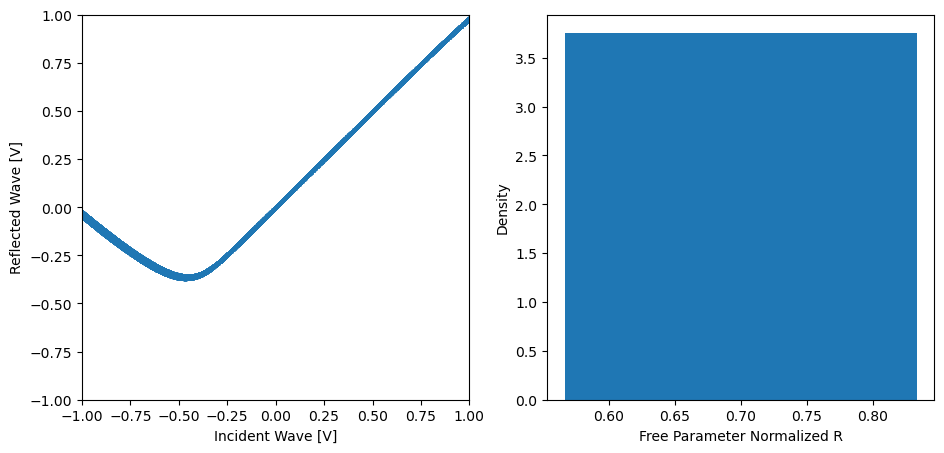

               [Train loss]    [Eval loss]     [Time left]
----------------------------------------------------------
Epoch     1		2.0191e-03		1.2945e-05		11.46 min
Epoch     2		1.5418e-05		1.1610e-05		11.43 min
Epoch     3		1.1874e-05		7.8796e-06		11.48 min
Epoch     4		9.8242e-06		6.9567e-06		11.70 min
Epoch     5		9.1990e-06		1.0151e-05		11.21 min
Epoch     6		8.3630e-06		6.3195e-06		11.08 min
Epoch     7		8.1892e-06		5.7598e-06		11.45 min
Epoch     8		8.1734e-06		7.2044e-06		10.95 min
Epoch     9		8.1006e-06		5.3165e-06		10.79 min
Epoch    10		8.0130e-06		1.0502e-05		10.66 min
Epoch    11		7.8220e-06		8.9431e-06		10.38 min
Epoch    12		7.7647e-06		5.0084e-06		10.34 min
Epoch    13		7.5959e-06		1.2446e-05		10.31 min
Epoch    14		7.7764e-06		1.0011e-05		10.32 min
Epoch    15		7.6937e-06		3.0702e-05		10.25 min
Epoch    16		7.7895e-06		4.7788e-06		10.18 min
Epoch    17		7.6204e-06		6.9645e-06		10.16 min
Epoch    18		7.6646e-06		9.9051e-06		10.01 min
Epoch    19		7.7957e-06		7.9102e-06	

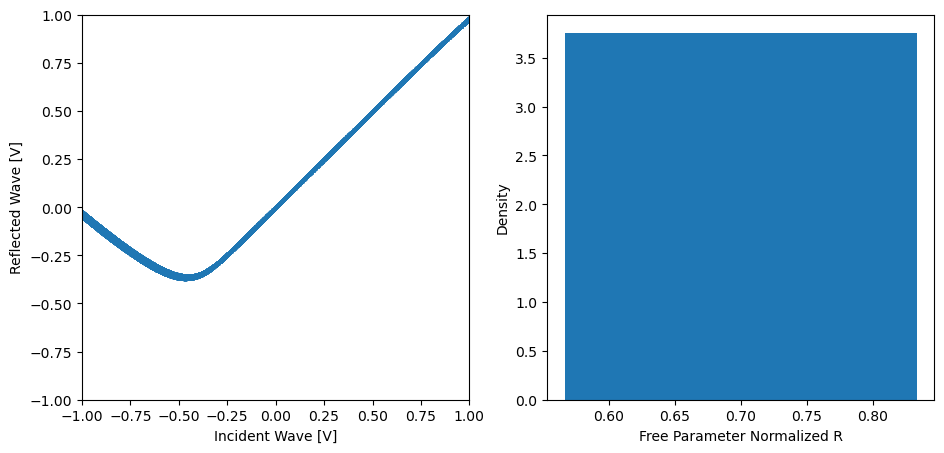

               [Train loss]    [Eval loss]     [Time left]
----------------------------------------------------------
Epoch     1		5.4143e-04		1.8429e-05		10.90 min
Epoch     2		1.1693e-05		7.1612e-06		11.30 min
Epoch     3		1.0602e-05		9.8820e-06		11.07 min
Epoch     4		1.0141e-05		6.9444e-06		11.39 min
Epoch     5		9.9212e-06		1.1643e-05		11.39 min
Epoch     6		9.3128e-06		6.0461e-06		11.11 min
Epoch     7		9.6214e-06		2.2458e-05		11.37 min
Epoch     8		9.1566e-06		1.4622e-05		11.64 min
Epoch     9		8.9265e-06		3.2791e-05		11.46 min
Epoch    10		9.0394e-06		5.6971e-06		11.03 min
Epoch    11		8.9204e-06		7.9965e-06		11.07 min
Epoch    12		8.6047e-06		6.5926e-06		10.99 min
Epoch    13		8.7258e-06		6.2977e-06		11.20 min
Epoch    14		8.5115e-06		7.8643e-06		10.34 min
Epoch    15		8.4272e-06		5.1560e-06		10.45 min
Epoch    16		8.4608e-06		1.0433e-05		10.29 min
Epoch    17		8.2905e-06		7.0001e-06		10.30 min
Epoch    18		8.7934e-06		5.6762e-06		10.23 min
Epoch    19		8.3590e-06		6.4360e-06	

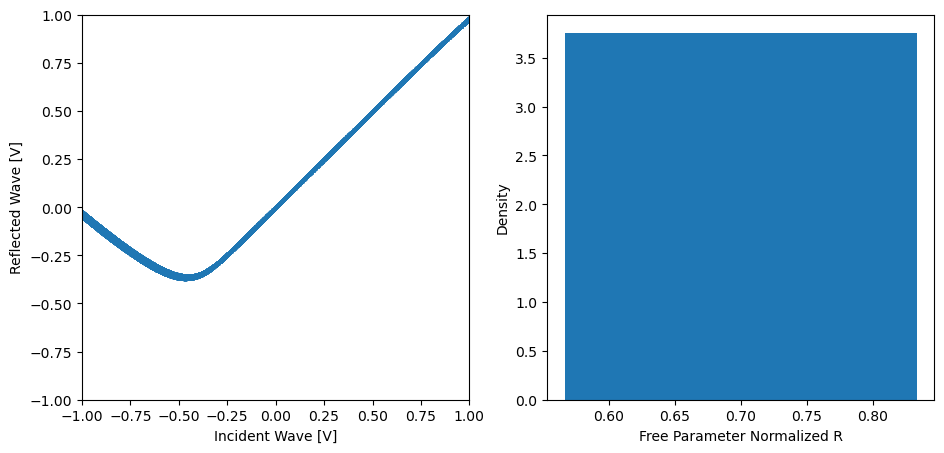

               [Train loss]    [Eval loss]     [Time left]
----------------------------------------------------------
Epoch     1		1.4989e-03		1.4503e-05		14.50 min
Epoch     2		1.1873e-05		3.3050e-05		14.12 min
Epoch     3		1.0981e-05		6.0964e-06		14.04 min
Epoch     4		1.0447e-05		6.2906e-06		14.38 min
Epoch     5		1.0134e-05		6.6332e-06		14.41 min
Epoch     6		9.7224e-06		4.9806e-06		13.99 min
Epoch     7		1.0311e-05		6.1745e-06		13.84 min
Epoch     8		1.0076e-05		6.3352e-06		14.21 min
Epoch     9		1.0055e-05		6.6967e-06		14.40 min
Epoch    10		1.0076e-05		5.4978e-06		13.94 min
Epoch    11		9.8271e-06		1.6917e-05		13.64 min
Epoch    12		1.0173e-05		2.0778e-05		13.79 min
Epoch    13		9.9492e-06		6.5826e-06		13.80 min
Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.
Epoch    14		9.8729e-06		6.1044e-06		13.38 min
Epoch    15		7.1475e-06		4.6680e-06		13.07 min
Epoch    16		7.1457e-06		7.3844e-06		12.61 min
Epoch    17		7.0081e-06		6.2262e-06		12.65 min
Epoch    18		7.1237e-

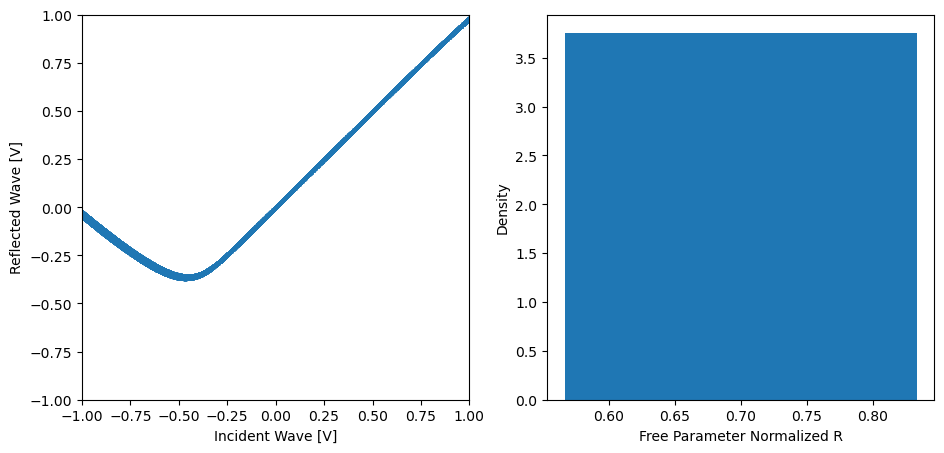

               [Train loss]    [Eval loss]     [Time left]
----------------------------------------------------------
Epoch     1		8.9708e-04		2.2990e-05		13.90 min
Epoch     2		1.5800e-05		9.1705e-06		13.58 min
Epoch     3		1.3791e-05		1.3613e-05		13.36 min
Epoch     4		1.3040e-05		1.4829e-05		13.33 min
Epoch     5		1.1984e-05		1.7835e-05		13.37 min
Epoch     6		1.1849e-05		2.1738e-05		13.65 min
Epoch     7		1.1423e-05		2.0485e-05		13.39 min
Epoch     8		1.1064e-05		7.2466e-06		13.31 min
Epoch     9		1.1410e-05		8.2174e-06		13.15 min
Epoch    10		1.0909e-05		1.6946e-05		13.00 min
Epoch    11		1.0482e-05		5.4840e-06		12.98 min
Epoch    12		1.0857e-05		5.8701e-06		13.22 min
Epoch    13		1.1029e-05		1.2191e-05		12.99 min
Epoch    14		1.0442e-05		1.1010e-05		12.88 min
Epoch    15		1.0831e-05		5.4605e-06		12.92 min
Epoch    16		1.0523e-05		8.4842e-06		12.74 min
Epoch    17		1.0418e-05		1.8851e-05		12.83 min
Epoch    18		1.0745e-05		9.0972e-06		12.74 min
Epoch    19		1.0680e-05		1.5210e-05	

In [10]:
import time
import pickle
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_up = 1
num_down = 3

num_layers_list = [2, 3]
layer_size_list = [16, 32]

epochs = 200
batch_size = 16

r_begin_list = [1.70e3]
r_end_list   = [2.50e3]

losses_dict = {}
for i, (r_begin, r_end) in enumerate(zip(r_begin_list, r_end_list)):
    for num_layers in num_layers_list:
        for layer_size in layer_size_list:
            print("\n\n\n======================")
            print(f"{num_layers}x{layer_size}, {r_begin} → {r_end}")
            print("======================\n")

            model = DiodePair(num_layers=num_layers, layer_size=layer_size).to(device)
            loss_func = nn.MSELoss()
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
            scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=7, verbose=True)
            train_dl, valid_dl, Fs = get_diodePair_dataloader(N=int(192e3), num_up=num_up, num_down=num_down, mode="LTspice", r_begin=r_begin, r_end=r_end, batch_size=batch_size, plot=True)

            train_losses, valid_losses = run_model(model, train_dl, valid_dl, epochs, loss_func, optimizer, scheduler)

            path_root = "./pre_trained_models"
            save_model(model, path_root = path_root, num_up=num_up, num_down=num_down, r_begin=r_begin, r_end=r_end, loss=valid_losses[-1])

            model_name = f"{num_up}u{num_down}d_{num_layers}x{layer_size}_{r_begin / 1000:.2f}k_{r_end / 1000:.2f}k"
            losses_dict[model_name] = {'train_losses': train_losses, 'valid_losses': valid_losses}

            # Save losses_dict after each model training
            with open('losses_dict.pickle', 'wb') as handle:
                pickle.dump(losses_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Plot Results

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(valid_losses, label='Valid Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (Log Scale)')
ax1.set_yscale('log')
ax1.legend()

with torch.no_grad():
    a = torch.linspace(-2, 2, 1000)

    r = 2000
    r_normalized = torch.ones_like(a) * torch.tensor(r) / 2.5e3

    b = model(torch.stack([a, r_normalized], dim=1))
    a = a.detach().numpy().reshape(-1, 1)
    b = b.detach().numpy()
    v = (a + b) / 2
    i = (a - b) / (2*r)

ax2.plot(v, i*1e3)
ax2.set_xlabel('Voltage [V]')
ax2.set_ylabel('Current [mA]')
ax2.set_xlim(-1, 1)
# ax2.set_ylim(-1e-2, 1e-2)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()